In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from dataloader import load_data_h5py
from train import train, stable_train
from torch.utils.tensorboard import SummaryWriter
from base_model import MultiHeadTransformerModel, ResidualTransformerModel, NF_ResidualTransformerModel, CUTS_Plus_Net
import os
import shutil
from visualization import plot_model_prediction, plot_generate_data
from UNN_Transformer import shareLSTM, shareMLP, shareTransformer, Residual_model
from generate import generate, generate_with_residual
if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    medical_path = '/ssd/0/wzq/unnset/unnset/datasets/medical/small/'
    batch_size = 36
    input_size = 20
    hidden_size = 128
    num_layers = 2
    num_heads = 4
    dropout = 0.1
    seq_length = 20
    num_epochs = 10
    learning_rate = 0.0001
    n_epochs = 100
    flow_length = 4
    gen_n = 20
    save_path = '/ssd/0/wzq/unnset/unnset/outputs/small/'
    log_dir = "/ssd/0/wzq/unnset/unnset/outputs/small/"
    task = 'medical'
    data_path = '/ssd/0/wzq/unnset/unnset/datasets/'
    save_path = save_path + task + '/'
    log_dir = log_dir + task + '/'
    summary_writer = SummaryWriter(log_dir=log_dir)
    train_loader, test_loader, val_loader, X, data_ori, mask, missing_rate = load_data_h5py(medical_path, batch_size, 20, data_type='pm2.5',test_size=0.2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model = Residual_model(input_size, hidden_size, mask, num_layers, 'decoder', hidden_size, dropout, type = 'LSTM').to(device)
    model = NF_ResidualTransformerModel(base_model, input_size*2, input_size*2, hidden_size, mask, num_layers, flow_length)
    model.load_state_dict(torch.load(save_path + 'NF.pth'))

In [12]:
import shap
model.train()

seq_length = 10
seq_list = []
target_list = []
test_data = data_ori[:800]
output_size = input_size
for i in range(len(test_data) - seq_length):
    seq = torch.Tensor(test_data[i:i+seq_length])
    target = torch.Tensor(test_data[i+seq_length]).unsqueeze(0)
    seq = seq.unsqueeze(0)
    seq_list.append(seq)
    target_list.append(target)

background = torch.cat(seq_list[:250], dim=0)
test_images = torch.cat(seq_list[250:254], dim=0)

# all 1 graph
full_connection_map = np.ones((36,36))
graph_model = model.base_model.full_model
train(graph_model, optimizer, criterion, train_loader, val_loader, device, save_path+'graph/', n_epochs, summary_writer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_model.to(device)
background = background.to(device)
test_images = test_images.to(device)    
e = shap.DeepExplainer(graph_model, background)

graph_model.train()
##Calculate for each category, each test image, each pixel, the corresponding shap value
shap_values = e.shap_values(test_images)
 
# save for faster reload
np.save('./shap_values2.npy', shap_values)

torch.Size([250, 10, 36]) torch.Size([4, 10, 36])
(36, 36)
(36, 36)
Epoch 1/100, Train Loss: 0.004160410995827988
Epoch 1/100, Val Loss: 0.0013629015237610373
Epoch 2/100, Train Loss: 0.001116931630032403
Epoch 2/100, Val Loss: 0.0011672181469664254
Epoch 3/100, Train Loss: 0.0008443034071076129
Epoch 3/100, Val Loss: 0.0010260149666228918
Epoch 4/100, Train Loss: 0.0007010788090493796
Epoch 4/100, Val Loss: 0.0009337621296354984
Epoch 5/100, Train Loss: 0.0006126342502622199
Epoch 5/100, Val Loss: 0.000855511439645111
Epoch 6/100, Train Loss: 0.0005490329400553101
Epoch 6/100, Val Loss: 0.0007975243310800489
Epoch 7/100, Train Loss: 0.0005193014384713024
Epoch 7/100, Val Loss: 0.0007590397287877129
Epoch 8/100, Train Loss: 0.0004852016712954667
Epoch 8/100, Val Loss: 0.000728678274888942
Epoch 9/100, Train Loss: 0.0004651085312278675
Epoch 9/100, Val Loss: 0.0006987864598095294
Epoch 10/100, Train Loss: 0.0004529877879290975
Epoch 10/100, Val Loss: 0.0006728161180810141
Epoch 11/100, 

KeyboardInterrupt: 

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


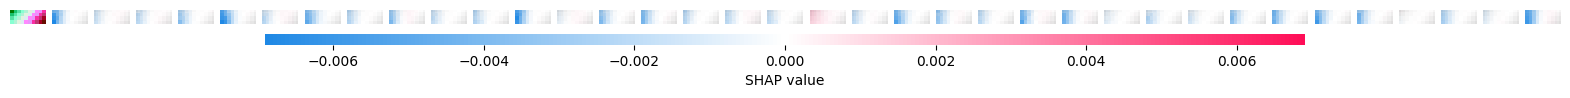

36
(4, 10, 36)


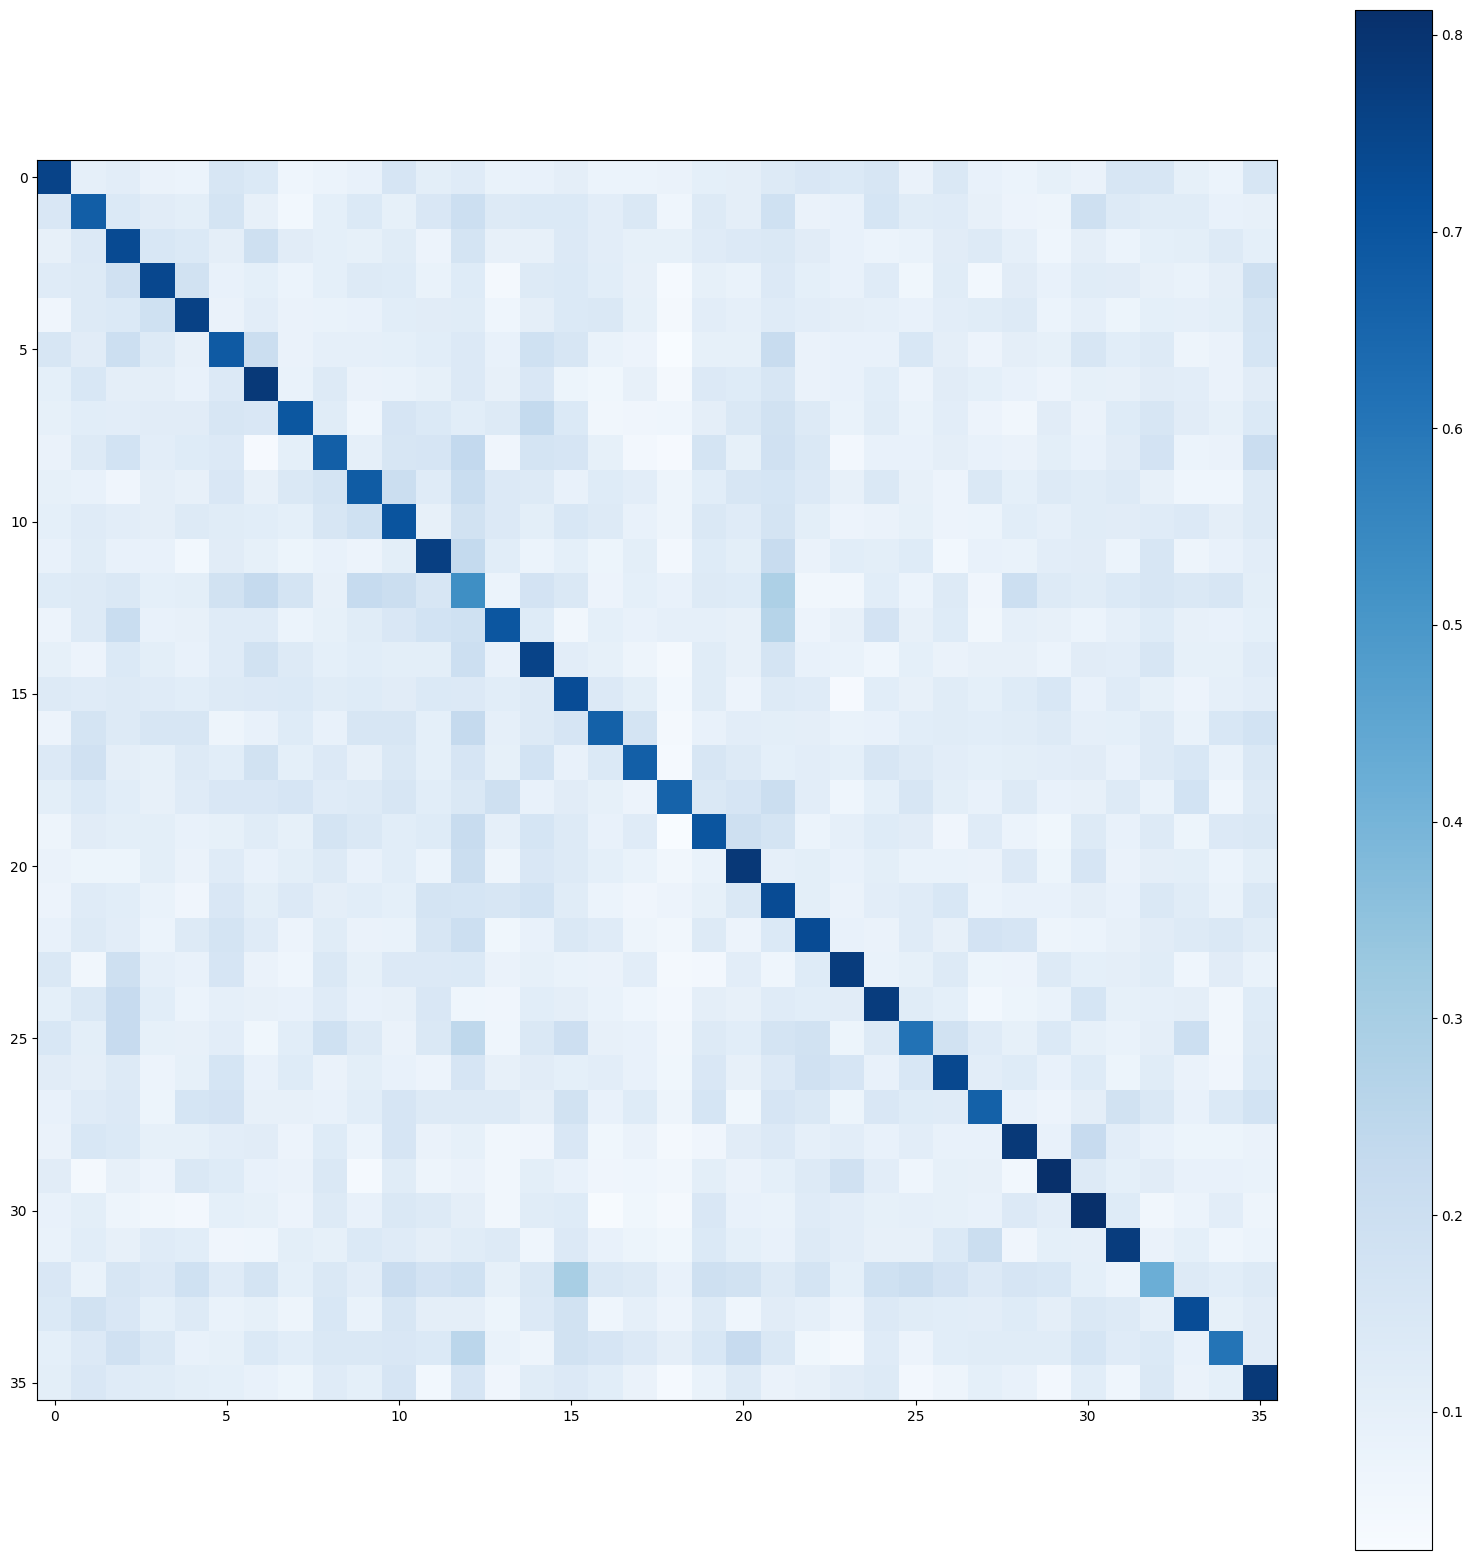

In [8]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Importing npy files
shap_values = np.load('shap_values2.npy', allow_pickle=True)

#shaply
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
 
##visualization
shap.image_plot(shap_numpy, -test_numpy)
print(len(shap_numpy))
print(shap_numpy[0].shape)
    
# sum
shap_numpy_sorted = []
shap_numpy_sum = []
for i in range(len(shap_numpy)):
    shap_numpy_sum.append(np.sum(np.abs(shap_numpy[i][1]), axis=0))
 
# turn into numpy array and Normalize rowsNormalize rows (sum of rows to 1)
shap_numpy_sum = np.array(shap_numpy_sum)
shap_numpy_sum = shap_numpy_sum / shap_numpy_sum.sum(axis=1, keepdims=1)
shap_numpy_sum = np.sqrt(shap_numpy_sum)

#heatmap
plt.figure(figsize=(20, 20))
plt.imshow(shap_numpy_sum, cmap='Blues')
plt.colorbar()
plt.show()

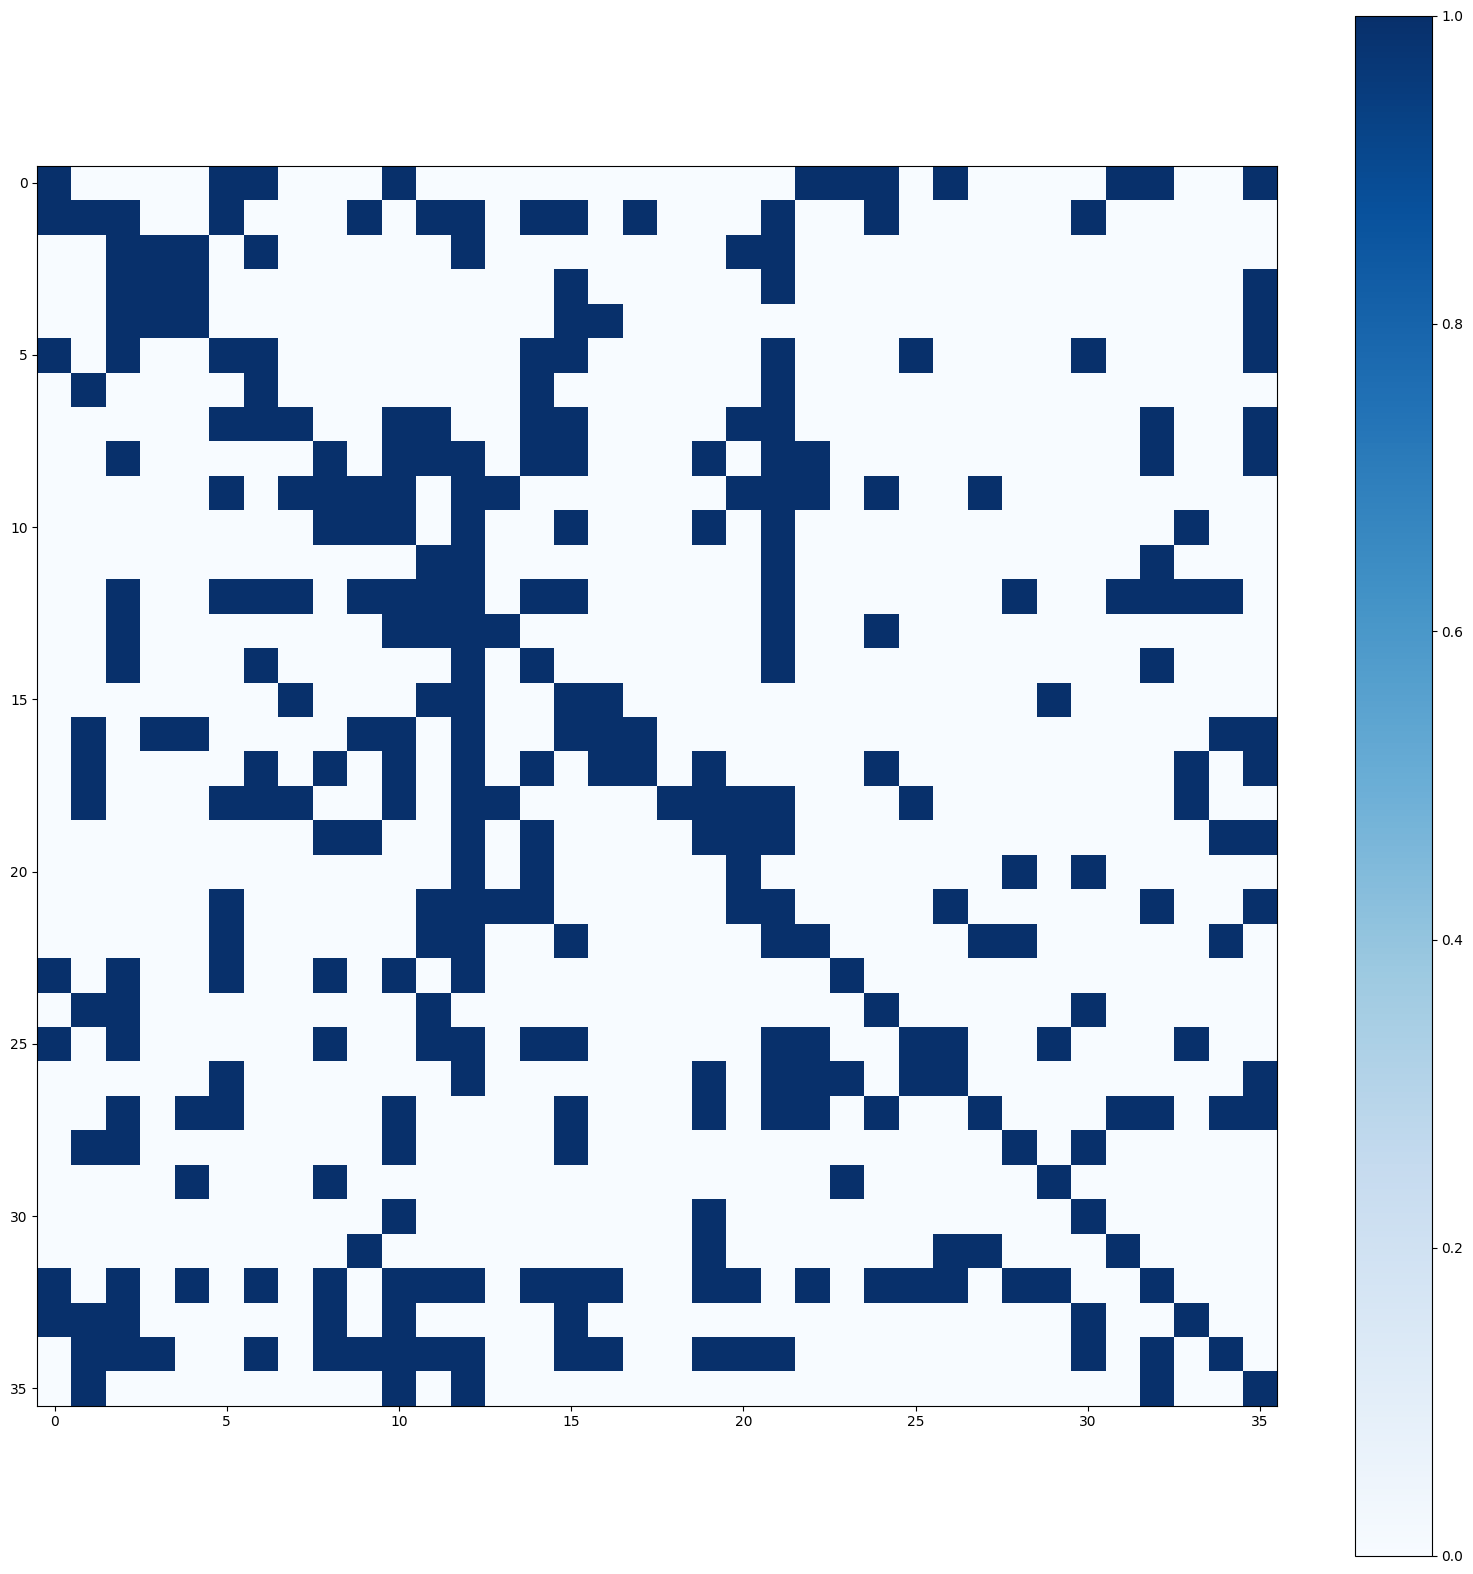

In [10]:
# Filtering the top 15% of important features for each output feature
shap_map = shap_numpy_sum
shap_map[shap_map < np.quantile(shap_map, 0.75)] = 0
shap_map[shap_map >= np.quantile(shap_map, 0.75)] = 1
plt.figure(figsize=(20, 20))
plt.imshow(shap_map, cmap='Blues')
plt.colorbar()
plt.show()
# save
np.save('/ssd/0/wzq/unnset/unnset/shap_map/shap_map2.npy', shap_map)